In [2]:
## https://github.com/intro-stat-learning/ISLP/blob/main/ISLP/transforms.py#L301

In [79]:
## General Imports

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
poly,
ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from patsy import dmatrix

## Lab Specific Imports
from pygam import (s as s_gam,
l as l_gam,
f as f_gam,
LinearGAM,
LogisticGAM)
from scipy.interpolate import BSpline
from ISLP.transforms import (BSpline,
NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
degrees_of_freedom,
plot as plot_gam,
anova as anova_gam)

## sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
## load wage data
wage = load_data('Wage')

# isolate variables
y = wage['wage']
age = wage['age']

display(wage)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [82]:
## We want to plot and add the fit from the fourth degree polynomial
## Defining a function that we will reuse throughout the lab

## Function that produces a fitted curve as well as 95% confidence bands
## We will use the basis arguement to plot different transforms in future uses
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
                y,
                facecolor='gray',
                alpha=0.5
                )
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('wage', fontsize=20);

    return ax

In [54]:
## This is how it's performed in the book
## BSpline is a class that generates the entire matrix of basis functions for splines with the specified set of knots


bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

bs_.knots_
## Results in a 7 column matrix. This is becasue we have a cubic-spline basis with 3 interior knots.

array([18., 18., 18., 18., 25., 40., 60., 80., 80., 80., 80.])

In [9]:
## We can also form this same matrix using the bs() object, which operates similarly to the poly() object from the previous section

bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


## Recreate this code in a machine learning context

(3000, 7)
Coefficients: [ 66.45970319  51.53997018 105.12469402 123.33250174 116.4845442
 108.53044581 -88.00718877]
Coef Names: ['x0_sp_0' 'x0_sp_1' 'x0_sp_2' 'x0_sp_3' 'x0_sp_4' 'x0_sp_5' 'x0_sp_6']
Intercept: 0.0


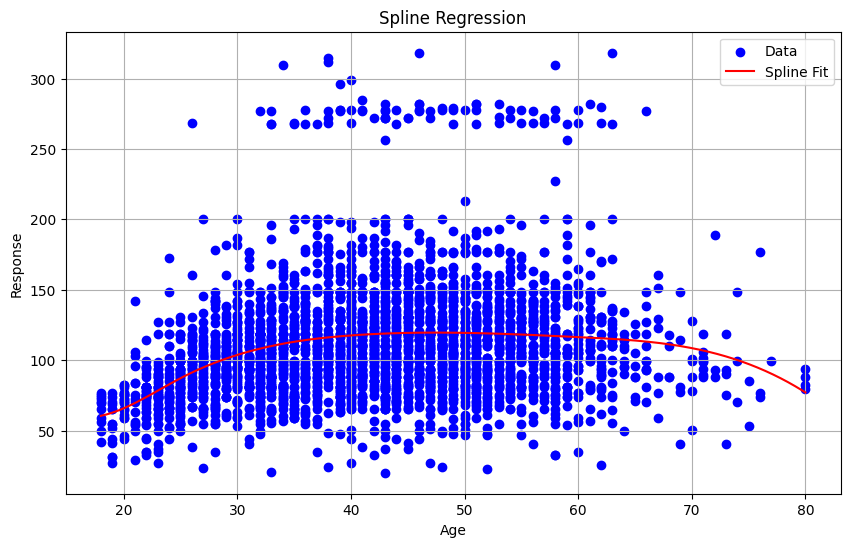

In [60]:
## Create the following using a sklearn Pipeline
## I'm not performing a train test split, just practicing the syntax in a machine learning setting
## It appears that when you use SplineTransformer, if you don't specify the max and the min as the outer knots, you will get the equivalent of a horizontal line as your basis function for all segments before and after the last knot specified
## In BSpline from ISLP, the logic of including the min and max of your predictor variable as the boundary knots is included in the logic.
## Additionally, this Transformer does result in slightly different coefficient values than BSpline, for reasons unknown. However, the predictions are still the same.

# Define the pipeline
pipeline = Pipeline([
    ('spline_features', SplineTransformer(degree=3, include_bias=True, knots=np.array([age.min(), 25, 40, 60, age.max()]).reshape(-1, 1))),  # You can change the degree if needed
    ('linear_regression', LinearRegression(fit_intercept=False))
])

pipeline.fit(age.to_numpy().reshape(-1,1), y)

print(pipeline['spline_features'].transform(age.to_numpy().reshape(-1,1)).shape)

# print(pipeline['spline_features'].fit_transform(age.to_numpy().reshape(-1,1), y))

# Print the coefficients and intercept of the linear regression model
print("Coefficients:", pipeline['linear_regression'].coef_)
print("Coef Names:", pipeline['spline_features'].get_feature_names_out())
print("Intercept:", pipeline['linear_regression'].intercept_)

# Predictions
age_range = np.linspace(age.min(), age.max(), 1000).reshape(-1, 1)
predictions = pipeline.predict(age_range)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(age, y, color='blue', label='Data')
plt.plot(age_range, predictions, color='red', label='Spline Fit')
plt.title('Spline Regression')
plt.xlabel('Age')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()

(3000, 7)
Coefficients: [ 60.49371419  64.47421387 105.12469402 123.33250174 116.4845442
 111.18181194  77.09985645]
Intercept: 0.0


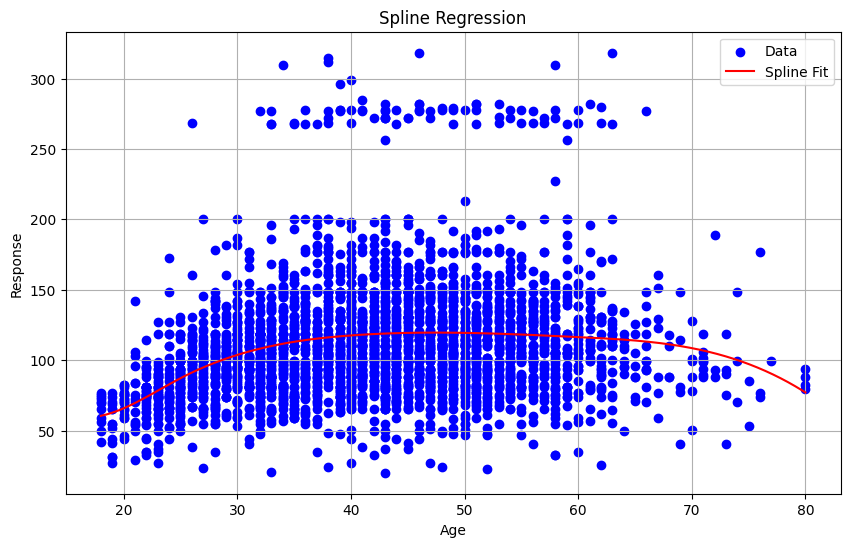

In [61]:
## Create the following using a sklearn Pipeline
## I'm not performing a train test split, just practicing the syntax in a machine learning setting
## Important to not here that SplineTransformer is using RAW POLYNOMIALS, so the results will differ

# Define the pipeline
pipeline = Pipeline([
    ('spline_features', BSpline(internal_knots=[25,40,60], intercept=True)),  # You can change the degree if needed
    ('linear_regression', LinearRegression(fit_intercept=False))
])

print(pipeline['spline_features'].fit_transform(age.to_numpy().reshape(-1,1)).shape)

pipeline.fit(age.to_numpy().reshape(-1,1), y)

# print(pipeline['spline_features'].fit_transform(age.to_numpy().reshape(-1,1), y))

# Print the coefficients and intercept of the linear regression model
print("Coefficients:", pipeline['linear_regression'].coef_)
# print("Coef Names:", pipeline['spline_features'].get_feature_names_out())
print("Intercept:", pipeline['linear_regression'].intercept_)

# Predictions
age_range = np.linspace(age.min(), age.max(), 1000).reshape(-1, 1)
predictions = pipeline.predict(age_range)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(age, y, color='blue', label='Data')
plt.plot(age_range, predictions, color='red', label='Spline Fit')
plt.title('Spline Regression')
plt.xlabel('Age')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()

## Back to ISLP

In [62]:
## Uses the degrees of freedom parameter to specify the complexity of the spline. 
## Df = 6 will product a spline with 3 knots chosen at uniform quantiles of the training data

BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [72]:
bs_age0 = MS([bs('age', df=3, degree=0)]).fit(wage)
Xbs0 = bs_age0.transform(wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


(3000, 4)
Coefficients: [ 94.15839203 116.50743565 118.96602073 116.93982301]
Coef Names: ['x0_sp_0' 'x0_sp_1' 'x0_sp_2' 'x0_sp_3']
Intercept: 0.0


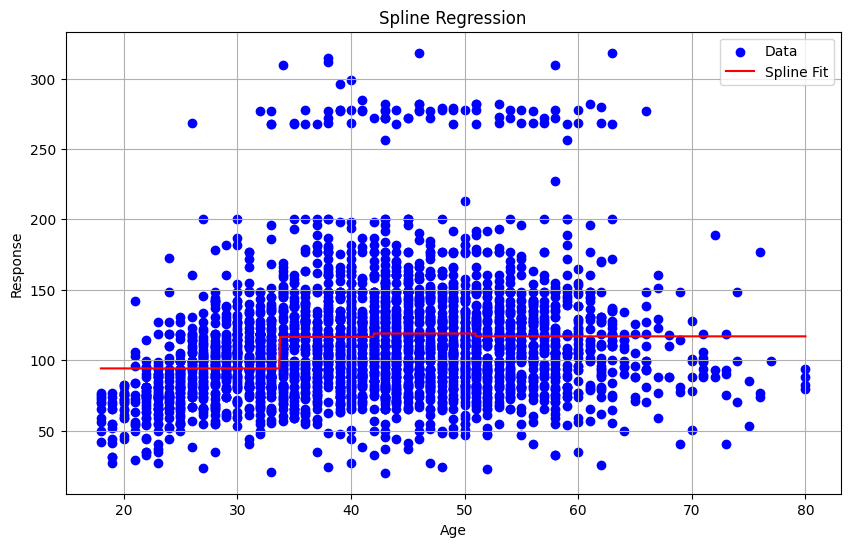

In [73]:
## Don't have to limit ourselves to cubic polynomials. Using degree 0 results in piecewise constant functions 
## This is actually the same result as in Lab 7.8.1, and the same result as above even though the coefficients are different
## It's a result of different coding. The intercept is coded by a column of 1s, so the following polynomial fits are increments for those bins in the above cell.
pipeline = Pipeline([
    ('spline_features', SplineTransformer(degree=0, knots='quantile', include_bias=True)),  # You can change the degree if needed
    ('linear_regression', LinearRegression(fit_intercept=False))
])

pipeline.fit(age.to_numpy().reshape(-1,1), y)

print(pipeline['spline_features'].transform(age.to_numpy().reshape(-1,1)).shape)

# print(pipeline['spline_features'].fit_transform(age.to_numpy().reshape(-1,1), y))

# Print the coefficients and intercept of the linear regression model
print("Coefficients:", pipeline['linear_regression'].coef_)
print("Coef Names:", pipeline['spline_features'].get_feature_names_out())
print("Intercept:", pipeline['linear_regression'].intercept_)

# Predictions
age_range = np.linspace(age.min(), age.max(), 1000).reshape(-1, 1)
predictions = pipeline.predict(age_range)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(age, y, color='blue', label='Data')
plt.plot(age_range, predictions, color='red', label='Spline Fit')
plt.title('Spline Regression')
plt.xlabel('Age')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()

## Natural Spline

In [113]:
NaturalSpline(df=5).fit(age).internal_knots_

array([32., 39., 46., 53.])

In [104]:
ns_age = MS([ns('age', df=5)]).fit(wage)

print(ns_age.transform(wage).shape)

M_ns = sm.OLS(y, ns_age.transform(wage)).fit()
summarize(M_ns)

(3000, 6)


,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


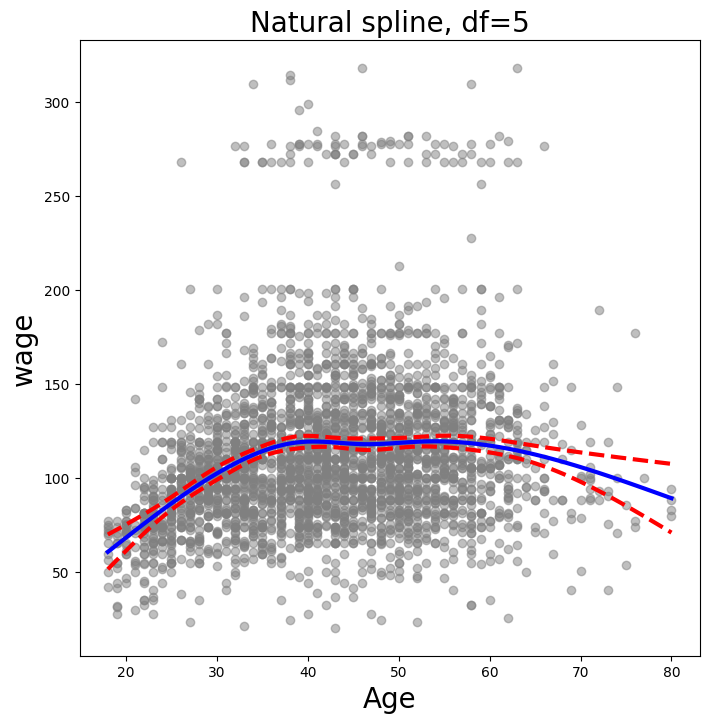

In [86]:
## Create a grid of values for age at which we want predictions

age_grid = np.linspace(age.min(),
age.max(),
100)
age_df = pd.DataFrame({'age': age_grid})

plot_wage_fit(age_df, ns_age, 'Natural spline, df=5');

(3000, 6)
Coefficients: [ 78.55529667 110.77920823 121.11091995 118.22925858 120.18980199
 111.45616649]
Coef Names: ['x0_sp_0' 'x0_sp_1' 'x0_sp_2' 'x0_sp_3' 'x0_sp_4' 'x0_sp_5']
Intercept: 0.0


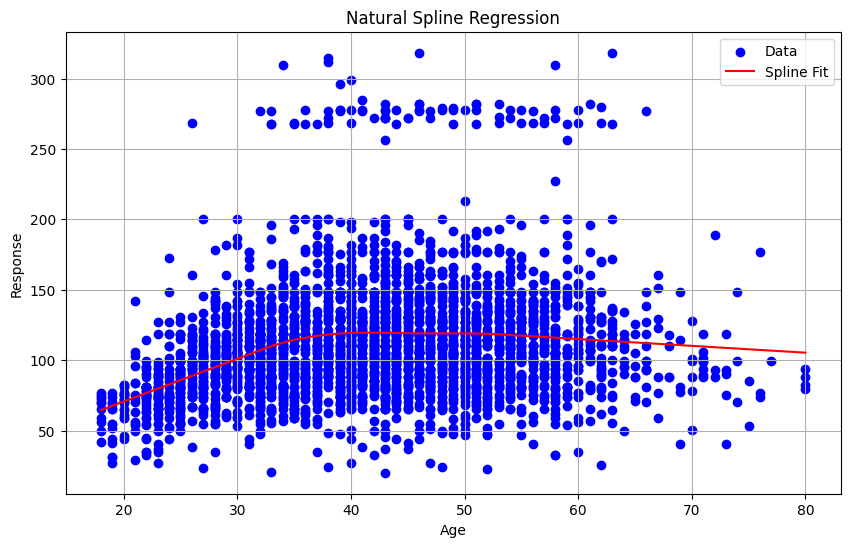

In [124]:
## Create the following using a sklearn Pipeline
## I'm not performing a train test split, just practicing the syntax in a machine learning setting
## It appears that when you use SplineTransformer, if you don't specify the max and the min as the outer knots, you will get the equivalent of a horizontal line as your basis function for all segments before and after the last knot specified
## In BSpline from ISLP, the logic of including the min and max of your predictor variable as the boundary knots is included in the logic.
## Additionally, this Transformer does result in slightly different coefficient values than BSpline, for reasons unknown. However, the predictions are still the same.

# Define the pipeline
pipeline = Pipeline([
    ('spline_features', SplineTransformer(degree=3, include_bias=True, extrapolation='linear', knots=np.array([32, 39, 46, 53]).reshape(-1,1))),  # You can change the degree if needed
    ('linear_regression', LinearRegression(fit_intercept=False))
])

pipeline.fit(age.to_numpy().reshape(-1,1), y)

print(pipeline['spline_features'].fit_transform(age.to_numpy().reshape(-1,1)).shape)

# print(pipeline['spline_features'].fit_transform(age.to_numpy().reshape(-1,1), y))

# Print the coefficients and intercept of the linear regression model
print("Coefficients:", pipeline['linear_regression'].coef_)
print("Coef Names:", pipeline['spline_features'].get_feature_names_out())
print("Intercept:", pipeline['linear_regression'].intercept_)

# Predictions
age_range = np.linspace(age.min(), age.max(), 1000).reshape(-1, 1)
predictions = pipeline.predict(age_range)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(age, y, color='blue', label='Data')
plt.plot(age_range, predictions, color='red', label='Spline Fit')
plt.title('Natural Spline Regression')
plt.xlabel('Age')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()